## 4. 如何计算投资组合风险？

## 目录
1. 什么是Markowitz方差组合模型？
2. Portfolioopt的输入格式是什么？
3. 如何计算组合风险？
4. 如何将Markowitz可视化？

## 什么是Markowitz方差组合模型？
马克维茨投资组合理论的基本假设为：

(1)投资者是风险规避的，追求期望效用最大化；

(2)投资者根据收益率的期望值与方差来选择投资组合；

(3)所有投资者处于同一单期投资期。马克维茨提出了以期望收益及其方差(E，δ2)确定有效投资组合。

## Portfolioopt的输入格式是什么？
安装Portfolioopt: pip install Portfolioopt

In [12]:
import pandas as pd
import tushare as ts
import numpy as np
import portfolioopt as opt
import matplotlib.pyplot as plt

codes = ['000001', '600036', '600050']
stocks_dict = {}
for c in codes:
    stock = ts.get_k_data(c, start='2015-01-01', end='2016-12-31', ktype='D', autype='qfq')
    stock.index = pd.to_datetime(stock['date'], format='%Y-%m-%d')
    stock.pop('date')
    stocks_dict[c] = stock

pn = pd.Panel(stocks_dict)
data_r = pn.minor_xs('close').pct_change()[1:]
print data_r.head()

              000001    600036    600050
date                                    
2015-01-06 -0.015000 -0.015595 -0.017161
2015-01-07 -0.019058 -0.015842  0.036706
2015-01-08 -0.033524 -0.036468 -0.059713
2015-01-09  0.007982  0.008942 -0.011805
2015-01-12 -0.020530 -0.007008 -0.026159


In [13]:
#主要的两个输入模式
exp_rets = data_r.mean()*252
cov_mat = data_r.cov()*252
print exp_rets
print cov_mat

000001   -0.031542
600036    0.122707
600050    0.326700
dtype: float64
          000001    600036    600050
000001  0.120180  0.086552  0.107306
600036  0.086552  0.110099  0.079702
600050  0.107306  0.079702  0.287795


In [14]:
#计算目标收益的权重
portfolio_1 = opt.markowitz_portfolio(cov_mat, exp_rets, 0.2, allow_short=False, market_neutral=False)
print portfolio_1

000001    2.983516e-07
600036    6.210984e-01
600050    3.789013e-01
dtype: float64


In [15]:
#计算最小方差的权重
portfolio_mv = opt.min_var_portfolio(cov_mat, allow_short=False)
print portfolio_mv

000001    0.368526
600036    0.583059
600050    0.048415
dtype: float64


In [16]:
#计算最优组合的权重
portfolio_tp = opt.tangency_portfolio(cov_mat, exp_rets, allow_short=False)
print portfolio_tp

000001    2.382544e-08
600036    2.615461e-01
600050    7.384539e-01
dtype: float64


In [17]:
#去除少于0.01权重的股票
weigth_t = opt.truncate_weights(portfolio_tp, min_weight=0.01, rescale=True)
print weigth_t

000001    0.000000
600036    0.261546
600050    0.738454
dtype: float64


## 如何计算组合风险？
$Portfolio Variance = x'\sum x$

x = weights

$\sum = Cov$

In [18]:
Portfolio_v = np.dot(weigth_t.T, np.dot(cov_mat,weigth_t))
P_sigma = np.sqrt(Portfolio_v)
print P_sigma

0.441879365552


## 如何将Markowitz可视化？

('sharpe:', 0.52807697151259214)


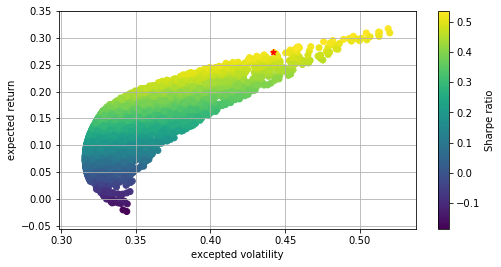

In [19]:
port_returns = []
port_variance = []
for p in range(4000):
    weights = np.random.rand(len(data_r.T))
    weights /= np.sum(weights)
    port_returns.append(np.sum(data_r.mean()*252*weights))
    port_variance.append(np.sqrt(np.dot(weights.T, np.dot(cov_mat,weights))))
port_returns = np.array(port_returns)
port_variance = np.array(port_variance)

risk_free = 0.04
P_r = np.sum(exp_rets*weigth_t)
sharpe = (P_r-risk_free)/P_sigma
print('sharpe:', sharpe)

plt.figure(figsize = (8,4))
plt.scatter(port_variance, port_returns, c=(port_returns-risk_free)/port_variance, marker='o')
plt.grid(True)
plt.xlabel('excepted volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.scatter(P_sigma, P_r, c='r', marker='*')
plt.show()

## 作业
选择三只或以上的股票，用Portfolioopt 将最优组合算出来，并将其可视化。